In [1]:
!pip install skyfield

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.9/466.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 6.4 MB/s eta 0:00:00


In [2]:
#本文档试图测试用三级三阶显式Heun方法计算50年轨道
from skyfield.api import load
from past.builtins import xrange
import numpy as np
class CelestialBody:
    def __init__(self, name, mass, position, velocity, radius):
        """
        初始化天体
        :param name: 天体名称 (str)
        :param mass: 质量 (kg)
        :param position: 初始位置 (numpy 数组, 单位 AU)
        :param velocity: 初始速度 (numpy 数组, 单位 AU/h)
        :param radius: 天体半径 (m) ## ！！注意！！ 这里有两个长度单位
        """
        self.name = name
        self.mass = mass
        self.pos = np.array(position, dtype=np.float64)
        self.velocity = np.array(velocity, dtype=np.float64)
        self.radius = radius

    def update_position(self, dt):
        """
        根据当前速度更新位置
        :param dt: 时间步长 (小时)
        """
        self.pos += self.velocity * dt

    def apply_force(self, force, dt):
        """
        根据合力计算速度变化
        :param force: 作用力 (numpy 数组, 单位 N)
        :param dt: 时间步长 (小时)
        """
        acceleration = force / self.mass  # a = F / m
        self.velocity += acceleration * dt * 3600  # 3600 秒 = 1 小时

    def __str__(self):
        return f"{self.name}: pos={self.position}, vel={self.velocity}"

    # 加载 JPL DE 精度表
ephemeris = load('de421.bsp')

# 获取天体对象
sun = ephemeris['sun']
earth = ephemeris['earth']
moon = ephemeris['moon']
venus = ephemeris['venus']
jupiter = ephemeris['jupiter barycenter']  # 木星的质心

# 设定时间为 2025 年 1 月 1 日 00:00 UTC
ts = load.timescale()
t = ts.utc(2025, 1, 1, 0, 0, 0)

t_m1 = ts.utc(2024, 12, 31, 21, 0)
t1 = ts.utc(2025, 1, 1, 3, 0, 0)

t2 = ts.utc(2025, 3, 31, 7, 3, 7)

# 计算相对于太阳的坐标 (单位：AU)
earth_pos = earth.at(t).observe(sun).position.km / 1.496e+8  # AU
earth_posm1 = earth.at(t_m1).observe(sun).position.km / 1.496e+8
earth_pos1 = earth.at(t1).observe(sun).position.km / 1.496e+8  # AU
earth_pos2 = earth.at(t2).observe(sun).position.km / 1.496e+8

earth_velocity = (earth_pos1 - earth_posm1) / 6 #AU/h
planet_masses = {
    "Sun": 1.989e30,
    "Mercury": 3.301e23,
    "Venus": 4.867e24,
    "Earth": 5.972e24,
    "Mars": 6.417e23,
    "Jupiter": 1.899e27,
    "Saturn": 5.683e26,
    "Uranus": 8.681e25,
    "Neptune": 1.024e26,
    "Moon": 7.348e22,
}

# 半径 (m)
planet_radii = {
    "Sun": 6.957e8,
    "Mercury": 2.439e6,
    "Venus": 6.052e6,
    "Earth": 6.378e6,
    "Mars": 3.390e6,
    "Jupiter": 7.149e7,
    "Saturn": 6.027e7,
    "Uranus": 2.556e7,
    "Neptune": 2.476e7,
    "Moon": 1.737e6,
}
# 归一化：利用(2025, 1, 1, 0, 0, 0)与(2025, 3, 31, 7, 3, 7)的地球数据进行归一化，确保earth_pos为[1, 0, 0]
earth_pos /= np.linalg.norm(earth_pos)
# print(np.linalg.norm(earth_pos2))
earth_pos2 /= np.linalg.norm(earth_pos2)
perp = np.cross(earth_pos,earth_pos2)
# print(perp)
A = np.vstack([earth_pos, earth_pos2, perp])
# print(np.linalg.det(A))
earth_pos = earth_pos @ A.T

moon_pos = (moon.at(t).observe(sun).position.km / 1.496e+8) @ A.T


[#################################] 100% de421.bsp


In [3]:
def get_initial(cb_name):
    if cb_name not in planet_radii:
        raise KeyError(f"Error: '{cb_name}' is not valid!")

    # 获取对应的星体对象
    body_map = {
        "Sun": sun,
        "Earth": earth,
        "Moon": moon,
        # 其他行星...
    }
    cb_obj = body_map[cb_name]

    # 计算位置和速度
    pos_m1 = cb_obj.at(t_m1).observe(sun).position.km / 1.496e8
    pos_t1 = cb_obj.at(t1).observe(sun).position.km / 1.496e8
    velocity = ((pos_t1 - pos_m1) / 6) @ A.T  # AU/h

    pos = (cb_obj.at(t).observe(sun).position.km / 1.496e8) @ A.T

    return CelestialBody(
        name=cb_name,
        mass=planet_masses[cb_name],
        position=pos,
        velocity=velocity,
        radius=planet_radii[cb_name]
    )


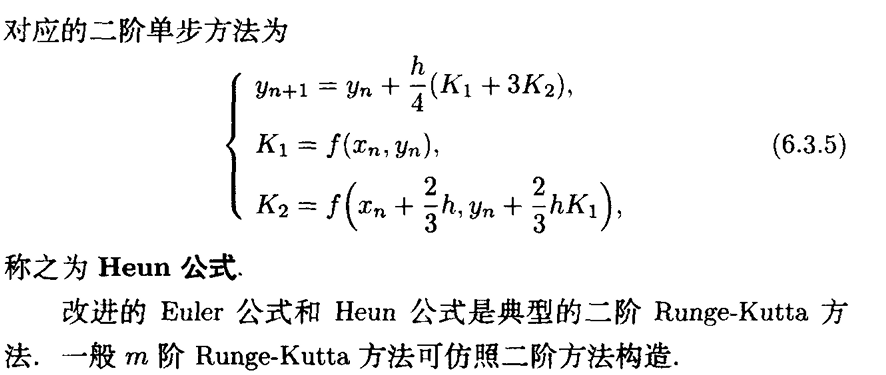

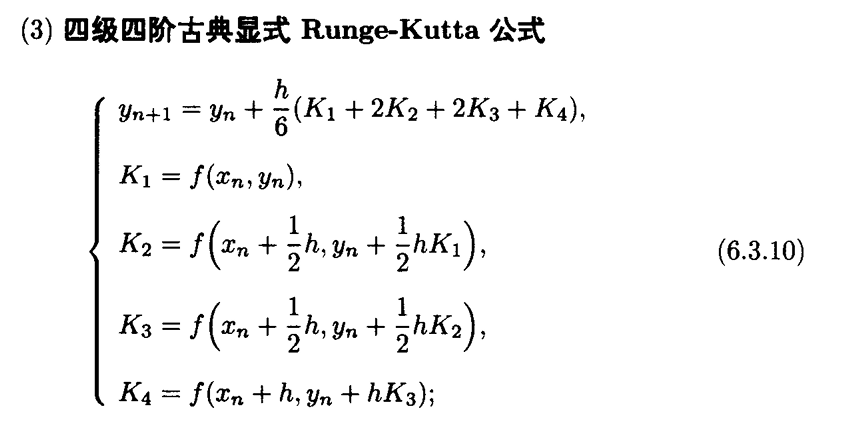

In [6]:
class ThreeBodySimulator:
    def __init__(self, bodies, G=6.67430e-11, dt=1):
        """
        :param bodies: list of CelestialBody objects
        :param G: 引力常数 (m^3 kg^-1 s^-2)
        :param dt: 时间步长 (小时)
        """
        self.bodies = bodies
        self.G = G * (3600**2) / (1.496e11)**3  # 转换为 AU^3 kg^-1 h^-2
        self.dt = dt

    def compute_forces(self, bodies=None):
        """
        计算所有天体间的引力
        :param bodies: 可选参数，指定要计算的天体列表
        """
        if bodies is None:
            bodies = self.bodies  # 默认使用类自身的天体列表
        forces = {body: np.zeros(3) for body in bodies}
        for i, body1 in enumerate(bodies):
            for body2 in bodies[i+1:]:
                r = body2.pos - body1.pos
                r_mag = np.linalg.norm(r)
                F = self.G * body1.mass * body2.mass / (r_mag **3) * r
                forces[body1] += F
                forces[body2] -= F
        return forces

    def heun_step(self):
        # 计算k1
        forces = self.compute_forces()
        k1_pos = {b: b.velocity * self.dt for b in self.bodies}
        k1_vel = {b: forces[b]/b.mass * self.dt for b in self.bodies}

        # 计算k2
        temp_bodies = []
        for b in self.bodies:
            new_b = CelestialBody(
                name=b.name,
                mass=b.mass,
                position=b.pos + 1/3 * k1_pos[b],
                velocity=b.velocity + 1/3 * k1_vel[b],
                radius=b.radius
            )
            temp_bodies.append(new_b)
            ## 用于计算forces的celestrial_body，取的是在平均相位受到的力，下同

        forces_k2 = self.compute_forces(temp_bodies)
        #k2_pos = {b: (b.velocity + 1/3 * k1_vel[orig]) * self.dt
        #         for b, orig in zip(temp_bodies, self.bodies)}
        k2_pos = {b: (b.velocity + 1/3 * k1_vel[orig]) * self.dt
                 for b, orig in zip(temp_bodies, self.bodies)}
        k2_vel = {b: forces_k2[b]/b.mass * self.dt
                 for b in temp_bodies}

        # 计算k3并更新
        for orig_b, temp_b in zip(self.bodies, temp_bodies):
            orig_b.pos += (1/4 * k1_pos[orig_b] + 3/4 * k2_pos[temp_b])
            orig_b.velocity += (1/4 * k1_vel[orig_b] + 3/4 * k2_vel[temp_b])

    def rk4(self):
      # 计算K1
      forces = self.compute_forces()
      k1_pos = {b: b.velocity * self.dt for b in self.bodies}
      k1_vel = {b: forces[b]/b.mass * self.dt for b in self.bodies}

      # 计算K2
      temp_bodies2 = []
      for b in self.bodies:
          new_b = CelestialBody(
              name=b.name,
              mass=b.mass,
              position=b.pos + 1/4 * k1_pos[b],
              velocity=b.velocity + 1/4 * k1_vel[b],
              radius=b.radius
          )
          temp_bodies2.append(new_b)

      forces_k2 = self.compute_forces(temp_bodies2)
      k2_pos = {orig: (b.velocity + 1/4 * k1_vel[orig]) * self.dt
                for b, orig in zip(temp_bodies2, self.bodies)}
      k2_vel = {orig: forces_k2[b]/b.mass * self.dt
                for b, orig in zip(temp_bodies2, self.bodies)}

      # 计算K3
      temp_bodies3 = []
      for b in self.bodies:
          new_b = CelestialBody(
              name=b.name,
              mass=b.mass,
              position=b.pos + 1/4 * k2_pos[b],
              velocity=b.velocity + 1/4 * k2_vel[b],
              radius=b.radius
          )
          temp_bodies3.append(new_b)

      forces_k3 = self.compute_forces(temp_bodies3)
      k3_pos = {orig: (b.velocity + 1/4 * k2_vel[orig]) * self.dt
                for b, orig in zip(temp_bodies3, self.bodies)}
      k3_vel = {orig: forces_k3[b]/b.mass * self.dt
                for b, orig in zip(temp_bodies3, self.bodies)}

      # 计算K4
      temp_bodies4 = []
      for b in self.bodies:
          new_b = CelestialBody(
              name=b.name,
              mass=b.mass,
              position=b.pos + 1/2 * k3_pos[b],
              velocity=b.velocity + 1/2 * k3_vel[b],
              radius=b.radius
          )
          temp_bodies4.append(new_b)

      forces_k4 = self.compute_forces(temp_bodies4)
      k4_pos = {orig: (b.velocity + 1/2 * k3_vel[orig]) * self.dt
                for b, orig in zip(temp_bodies4, self.bodies)}
      k4_vel = {orig: forces_k4[b]/b.mass * self.dt
                for b, orig in zip(temp_bodies4, self.bodies)}
      # Runge - Kutta
      for b in self.bodies:
        b.pos += (1/6 * k1_pos[b] + 1/3 * k2_pos[b] + 1/3 * k3_pos[b] + 1/6 * k4_pos[b])
        b.velocity += (1/6 * k1_vel[b] + 1/3 * k2_vel[b] + 1/3 * k3_vel[b] + 1/6 * k4_vel[b])


    def simulate(self, years=50):
        steps = int(years * 365 * 24 / self.dt)
        # 修改为存储NumPy数组
        trajectories = {b.name: np.zeros((steps, 3)) for b in self.bodies}  # 预分配数组

        for step in range(steps):
            for i, body in enumerate(self.bodies):
                trajectories[body.name][step] = body.pos.copy()  # 直接填充数组
                # 原代码中的列表append改为数组赋值
            self.heun_step()

        return trajectories


    def simulate_rk4(self, years = 50):
      steps = int(years * 365 * 24 / self.dt)
        # 修改为存储NumPy数组
      trajectories_rk4 = {b.name: np.zeros((steps, 3)) for b in self.bodies}  # 预分配数组

      for step in range(steps):
          for i, body in enumerate(self.bodies):
              trajectories_rk4[body.name][step] = body.pos.copy()  # 直接填充数组
              # 原代码中的列表append改为数组赋值
          self.rk4()

      return trajectories_rk4


In [16]:
# 初始化天体

sun_body = get_initial("Sun")
earth_body = get_initial("Earth")
moon_body = get_initial("Moon")

sun_body1 = get_initial("Sun")
earth_body1 = get_initial("Earth")
moon_body1 = get_initial("Moon")

sun_body2 = get_initial("Sun")
earth_body2 = get_initial("Earth")
moon_body2 = get_initial("Moon")


# 创建模拟器（时间步长设为6小时）
simulator1 = ThreeBodySimulator(
    bodies=[sun_body1, earth_body1, moon_body1],
    dt=0.5
)
simulator2 = ThreeBodySimulator(
    bodies=[sun_body2, earth_body2, moon_body2],
    dt=0.5
)
simulator = ThreeBodySimulator(
    bodies=[sun_body, earth_body, moon_body],
    dt=0.5
)


# 运行8年模拟
trajectories_10years = simulator1.simulate(years=8)
# trajectories_50years = simulator.simulate(years=50)
traj_rk4_10yrs = simulator2.simulate_rk4(years=8)
#traj_20 = simulator.simulate(years=10)

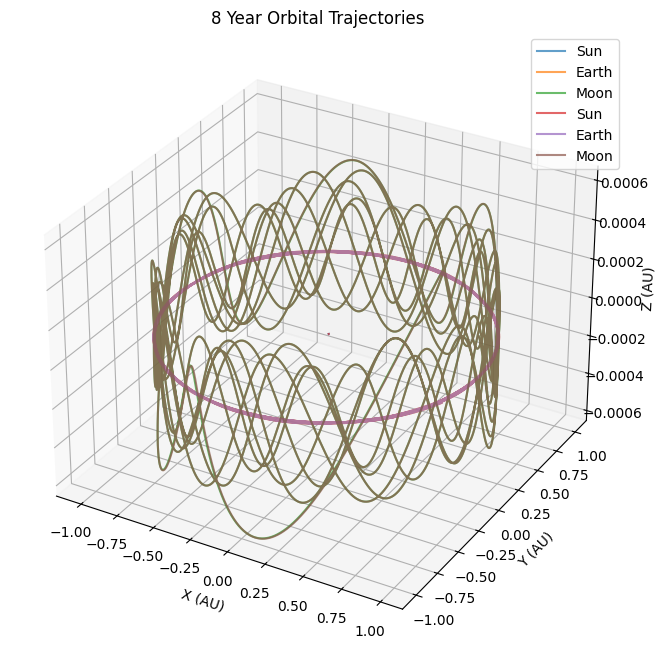

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_trajectories():
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    '''for name, pos_list in trajectories_5years.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.7)'''
    for name, pos_list in trajectories_10years.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.7)
    for name, pos_list in traj_rk4_10yrs.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.7)
    '''for name, pos_list in traj_20.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.6)'''

    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title('8 Year Orbital Trajectories')
    ax.legend()
    plt.show()




# 运行绘图
plot_trajectories()

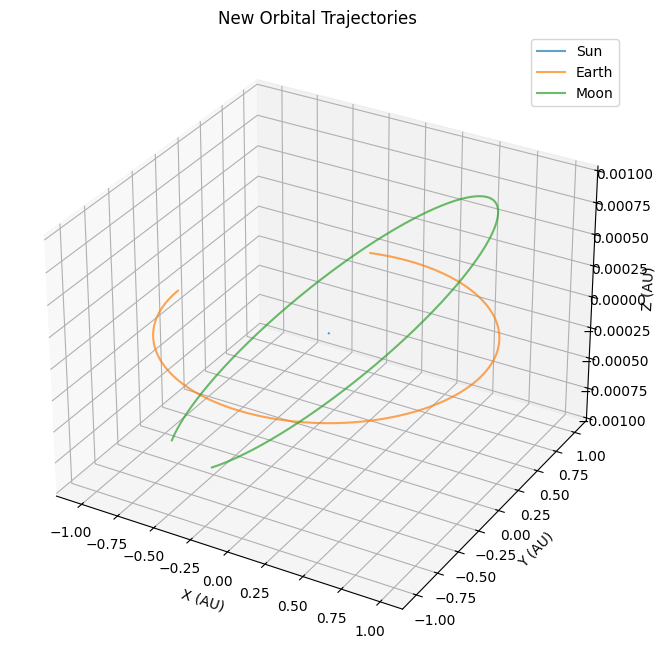

In [23]:
trajectories_8yearsnew = simulator1.simulate(years= 0.8)
traj_rk4_8yrsnew = simulator2.simulate(years = 0.8)

def plot_trajectories():
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    '''for name, pos_list in trajectories_5years.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.7)'''
    for name, pos_list in trajectories_8yearsnew.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.7)
    '''for name, pos_list in traj_rk4_8yrsnew.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.7)
    for name, pos_list in traj_20.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.6)'''

    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title('New Orbital Trajectories')
    ax.legend()
    plt.show()

# 运行绘图
plot_trajectories()
## 这里是第八年后+0.8年的天体运动

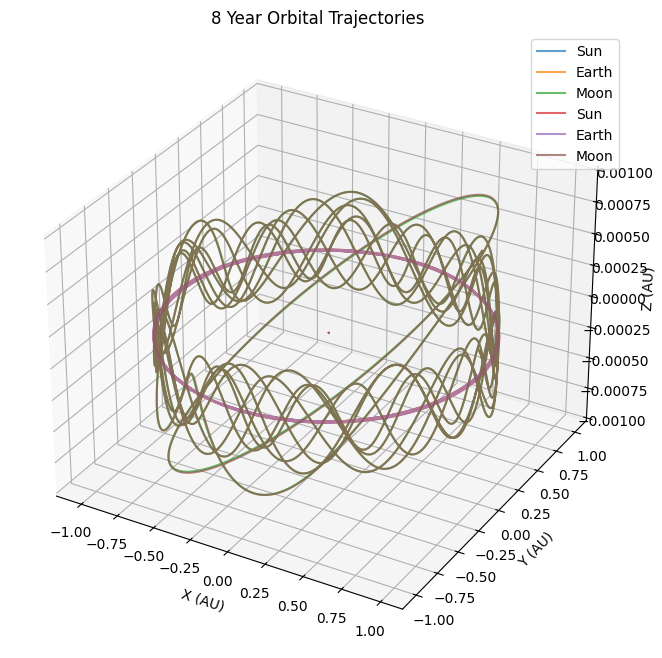

In [20]:
sun_body11 = get_initial("Sun")
earth_body11 = get_initial("Earth")
moon_body11 = get_initial("Moon")

sun_body21 = get_initial("Sun")
earth_body21 = get_initial("Earth")
moon_body21 = get_initial("Moon")


# 创建模拟器（时间步长设为6小时）
simulator1 = ThreeBodySimulator(
    bodies=[sun_body11, earth_body11, moon_body11],
    dt=0.5
)
simulator2 = ThreeBodySimulator(
    bodies=[sun_body21, earth_body21, moon_body21],
    dt=0.5
)

trajectories_10years1 = simulator1.simulate(years=9)
# trajectories_50years = simulator.simulate(years=50)
traj_rk4_10yrs1 = simulator2.simulate_rk4(years=9)

def plot_trajectories1():
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    '''for name, pos_list in trajectories_5years.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.7)'''
    for name, pos_list in trajectories_10years1.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.7)
    for name, pos_list in traj_rk4_10yrs1.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.7)
    '''for name, pos_list in traj_20.items():
        positions = np.array(pos_list)
        ax.plot(positions[:,0], positions[:,1], positions[:,2],
                label=name, alpha=0.6)'''

    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title('8 Year Orbital Trajectories')
    ax.legend()
    plt.show()

plot_trajectories1()

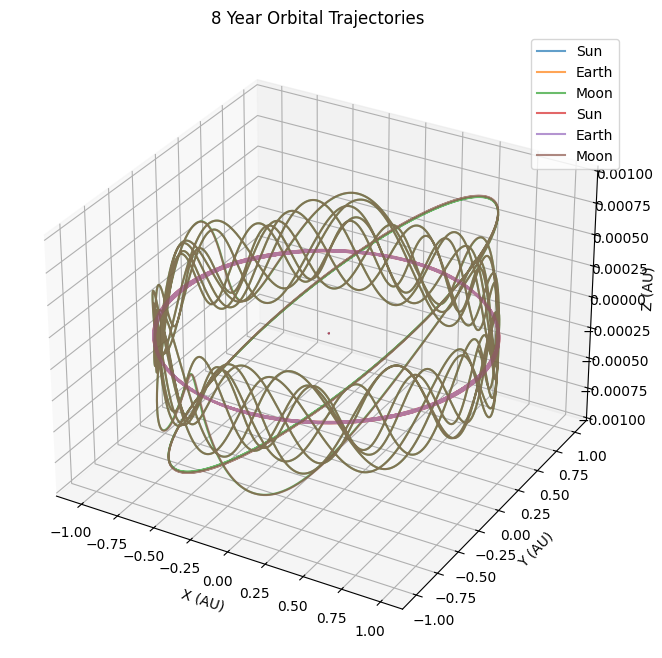

In [19]:
# 上面是9年的
# 这个是10年的

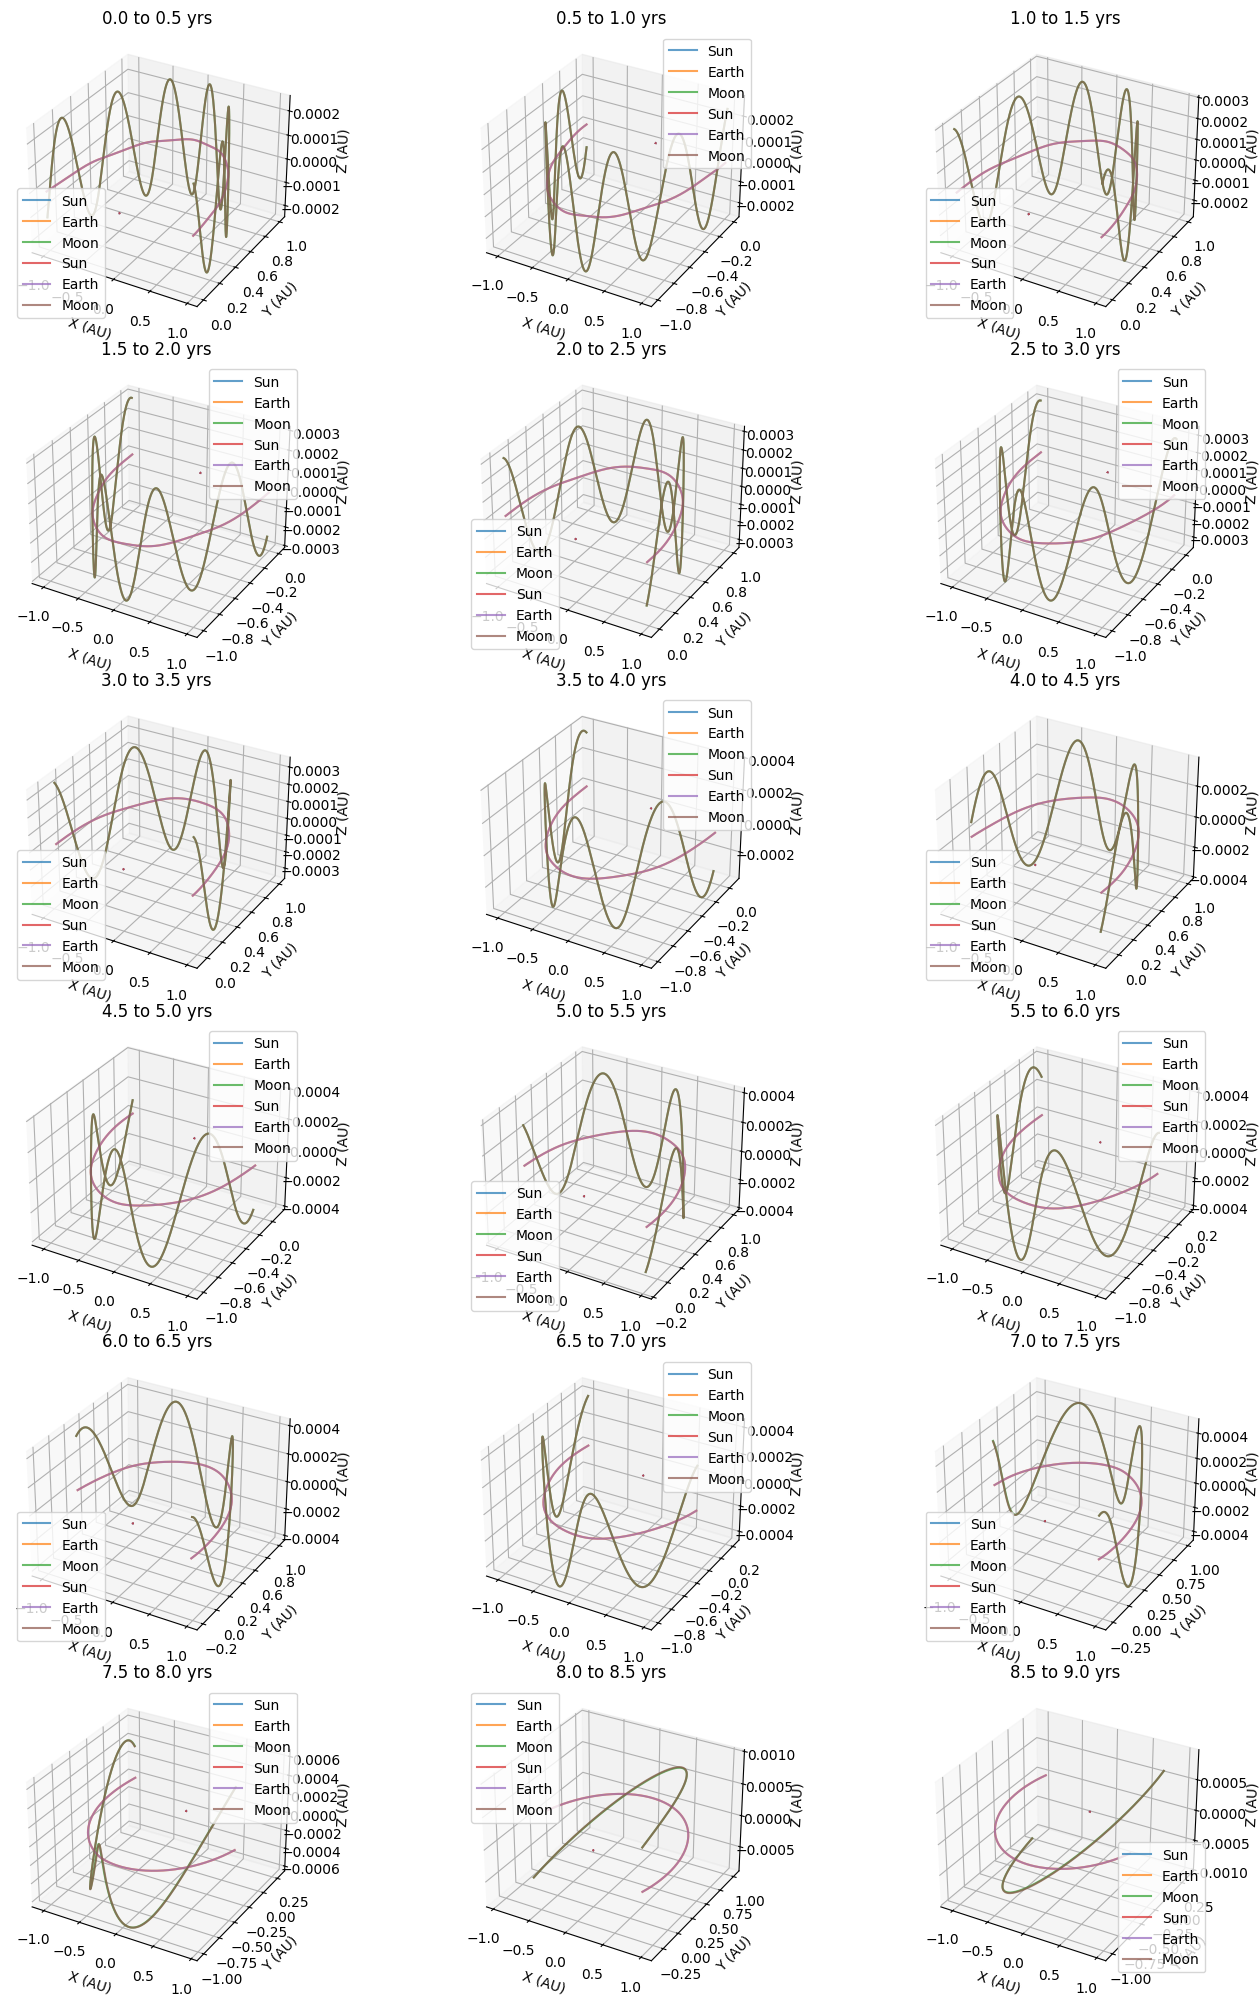

In [25]:
def plot_trajectories2():

    sun_body1 = get_initial("Sun")
    earth_body1 = get_initial("Earth")
    moon_body1 = get_initial("Moon")

    sun_body2 = get_initial("Sun")
    earth_body2 = get_initial("Earth")
    moon_body2 = get_initial("Moon")

    simulator1 = ThreeBodySimulator(
        bodies=[sun_body1, earth_body1, moon_body1],
        dt=0.5
    )
    simulator2 = ThreeBodySimulator(
        bodies=[sun_body2, earth_body2, moon_body2],
        dt=0.5
    )



    fig, ax = plt.subplots(6, 3, figsize=(15, 20), subplot_kw={'projection': '3d'})

    for i, ax in enumerate(ax.flat):

      trajectories_years = simulator1.simulate(years=0.5)
      traj_rk4_yrs = simulator2.simulate_rk4(years=0.5)

      for name, pos_list in trajectories_years.items():
          positions = np.array(pos_list)
          ax.plot(positions[:,0], positions[:,1], positions[:,2],
                  label=name, alpha=0.7)
      for name, pos_list in traj_rk4_yrs.items():
          positions = np.array(pos_list)
          ax.plot(positions[:,0], positions[:,1], positions[:,2],
                  label=name, alpha=0.7)

      ax.set_xlabel('X (AU)')
      ax.set_ylabel('Y (AU)')
      ax.set_zlabel('Z (AU)')
      ax.set_title(f"{i * 0.5} to {(i+1) * 0.5} yrs")
      ax.legend()

    plt.tight_layout()
    plt.show()

plot_trajectories2()

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from itertools import cycle

def create_orbital_animation(trajectories, save_as_gif=False):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 转换所有轨迹为NumPy数组（如果之前存储的是列表）
    for name in trajectories:
        if isinstance(trajectories[name], list):
            trajectories[name] = np.array(trajectories[name])

    # 初始化图形元素
    lines = {}
    points = {}
    colors = cycle(['gold', 'blue', 'gray'])
    max_points = 500

    for name, color in zip(trajectories.keys(), colors):
        lines[name], = ax.plot([], [], [], '-', color=color, alpha=0.5, lw=1)
        points[name], = ax.plot([], [], [], 'o', markersize=4, color=color)

    # 设置坐标范围
    all_pos = np.concatenate(list(trajectories.values()))
    max_range = np.max(np.abs(all_pos)) * 1.2
    ax.set(xlim=[-max_range, max_range], ylim=[-max_range, max_range], zlim=[-max_range, max_range])

    def update(frame):
        current_year = int(frame * 50 / len(trajectories['Sun']))
        ax.set_title(f'Real-time Orbital Simulation\nYear: {current_year}')

        for name in trajectories:
            # 直接访问NumPy数组
            current_data = trajectories[name][:frame+1]

            # 处理可见数据范围
            if frame+1 > max_points:
                visible_data = current_data[-max_points:]
            else:
                visible_data = current_data

            # 更新轨迹
            lines[name].set_data(visible_data[:,0], visible_data[:,1])
            lines[name].set_3d_properties(visible_data[:,2])

            # 更新当前位置
            points[name].set_data([current_data[-1,0]], [current_data[-1,1]])
            points[name].set_3d_properties([current_data[-1,2]])

        ax.view_init(elev=30, azim=frame*0.5 % 360)
        return list(lines.values()) + list(points.values())

    # 创建动画
    frames = len(trajectories['Sun'])
    ani = animation.FuncAnimation(
        fig, update, frames=frames, interval=20, blit=True
    )

    if save_as_gif:
        ani.save('orbits.gif', writer='pillow', fps=30)

    plt.show()
    return ani

In [27]:
import numpy as np
from astropy.time import Time
from scipy.spatial import distance

def detect_eclipses(trajectories, time_steps, threshold_angle=0.5, shadow_radius=0.01):
    """
    检测日食和月食事件
    :param trajectories: 字典，包含各天体的轨迹数组（shape: [n_steps, 3]）
    :param time_steps: 时间戳列表（datetime对象或astropy.Time对象）
    :param threshold_angle: 最大允许偏离角度（度）
    :param shadow_radius: 地球本影半径比例（AU）
    :return: 包含日食和月食事件的字典
    """
    # 天体名称硬编码（根据实际情况调整）
    sun_pos = trajectories['Sun']
    earth_pos = trajectories['Earth']
    moon_pos = trajectories['Moon']

    # 转换为astropy.Time对象（如果输入是datetime）
    if isinstance(time_steps[0], (Time, float)):
        times = Time(time_steps, format='jd')
    else:
        times = Time(time_steps)

    # 预处理计算关键向量
    earth_to_sun = sun_pos - earth_pos
    earth_to_moon = moon_pos - earth_pos
    moon_to_sun = sun_pos - moon_pos

    # 标准化向量
    earth_sun_dir = earth_to_sun / np.linalg.norm(earth_to_sun, axis=1)[:, None]
    earth_moon_dir = earth_to_moon / np.linalg.norm(earth_to_moon, axis=1)[:, None]
    moon_sun_dir = moon_to_sun / np.linalg.norm(moon_to_sun, axis=1)[:, None]

    # 计算关键角度
    solar_eclipse_angle = np.degrees(np.arccos(
        np.clip(np.sum(earth_sun_dir * earth_moon_dir, axis=1), -1, 1)
    ))
    lunar_eclipse_angle = np.degrees(np.arccos(
        np.clip(np.sum(moon_sun_dir * (-earth_moon_dir), axis=1), -1, 1)
    ))

    # 日食条件：月球位于地球-太阳连线附近，且在地球朝向太阳的一侧
    solar_condition = (
        (solar_eclipse_angle > (180 - threshold_angle)) &  # 1. 添加括号明确运算顺序
        (np.linalg.norm(earth_to_moon, axis=1) < np.linalg.norm(earth_to_sun, axis=1))  # 2. 补全括号
    )

    # 月食条件：地球位于月球-太阳连线附近，且月球进入地球本影
    lunar_condition = (
        (lunar_eclipse_angle < threshold_angle) &
        (distance.cdist(moon_pos, earth_pos) < shadow_radius)
    )

    # 检测连续时间段
    def find_events(condition):
        events = []
        in_event = False
        start_idx = 0
        for i, cond in enumerate(condition):
            if cond and not in_event:
                in_event = True
                start_idx = i
            elif not cond and in_event:
                in_event = False
                events.append((start_idx, i-1))
        if in_event:
            events.append((start_idx, len(condition)-1))
        return events

    solar_events = find_events(solar_condition)
    lunar_events = find_events(lunar_condition)

    # 转换为时间信息
    def format_events(event_indices):
        return [{
            'start': times[start].isot,
            'end': times[end].isot,
            'duration': (times[end] - times[start]).to('hour').value
        } for (start, end) in event_indices]

    return {
        'solar_eclipses': format_events(solar_events),
        'lunar_eclipses': format_events(lunar_events)
    }


# 1. 生成数值数组
time_values = np.linspace(2025.0, 2075.0, len(trajectories['Sun']))
# 2. 转换为 Time 对象时指定格式
time_steps = Time(time_values, format='jyear')

results = detect_eclipses(trajectories, time_steps)

print("日食事件：")
for event in results['solar_eclipses']:
    print(f"开始时间：{event['start']} 持续时间：{event['duration']:.2f}小时")

print("\n月食事件：")
for event in results['lunar_eclipses']:
    print(f"开始时间：{event['start']} 持续时间：{event['duration']:.2f}小时")

NameError: name 'trajectories' is not defined